# Evaluation notebook

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
from dataset import PROMPT_TEMPLATE
from evaluate import load
import torch
from tqdm import tqdm

MODEL = "Qwen/Qwen2.5-1.5B-Instruct"
DATASET = "rajpurkar/squad"
MAX_PROMPT_LEN = 460

## Load model and create inference pipeline

In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
template = tokenizer.apply_chat_template(
    [
        {
            "role": "user",
            "content": """Here is the question you need to answer. Question: {question}\nInstruction: Answer with the shortest, most precise answer possible ideally with one word. Example: When did the first world war started?\nAnswer: 1914"""
        }
    ],tokenize=False, add_generation_prompt=True
)
model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype=torch.bfloat16,
    device_map='mps'
)

llm_pipeline = pipeline(
        model=model,
        tokenizer=tokenizer,
        task="text-generation",
        do_sample=True,
        temperature=0.2,
        repetition_penalty=1.1,
        return_full_text=False,
        max_new_tokens=500,
    )
rouge = load("rouge")
bleu = load("bleu")
test = load_dataset(DATASET, split="validation").shuffle(seed=42)
test = test.select(range(len(test)//2))

## Run evaluation

In [3]:
model.eval()
results = []
labels = []

with torch.no_grad():
    for example in tqdm(test):
        prompt = template.format(question=example["question"])
        output = llm_pipeline(prompt)[0]['generated_text']
        results.append(output)
        labels.append(example["answers"]["text"])

100%|██████████| 5285/5285 [1:12:39<00:00,  1.21it/s]


In [ ]:
import json

bertscore = load("bertscore")
def accuracy(results, labels):
    num_correct = 0
    for i, res in enumerate(results):
        if res in labels[i]:
            num_correct += 1
    return num_correct / len(results)

In [18]:
rouge_res = rouge.compute(predictions=results, references=labels)
bleu_res = bleu.compute(predictions=results, references=labels)
bertscore_res = bertscore.compute(predictions=results, references=labels, lang="en")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/anaconda3/envs/praca/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
eval_dict = {
    'rouge': rouge_res,
    'bleu': bleu_res,
    'accuracy': accuracy(results, labels),
    'bertscore': bertscore_res
}
with open("eval_base.json", "w") as file:
    json.dump(eval_dict, file)

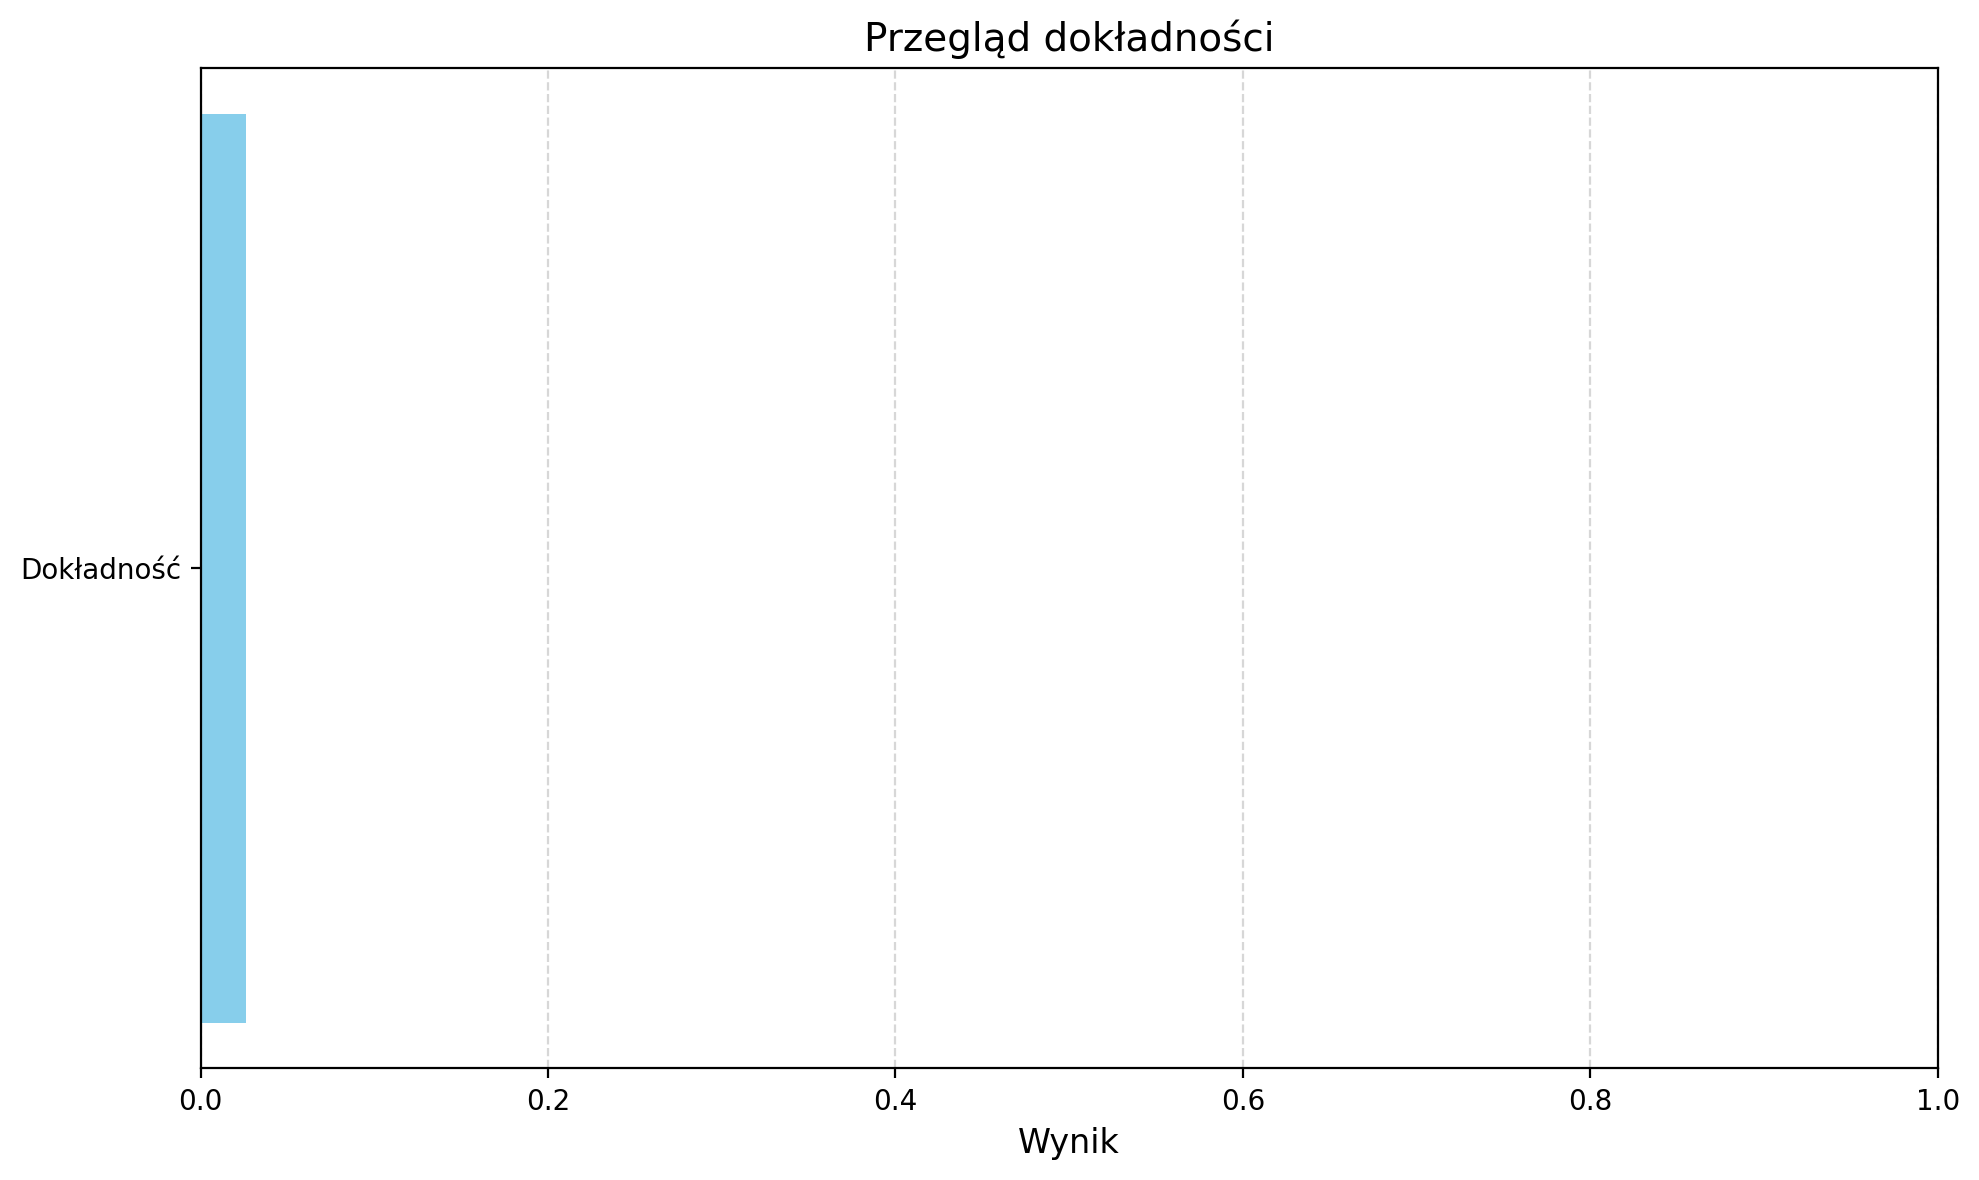

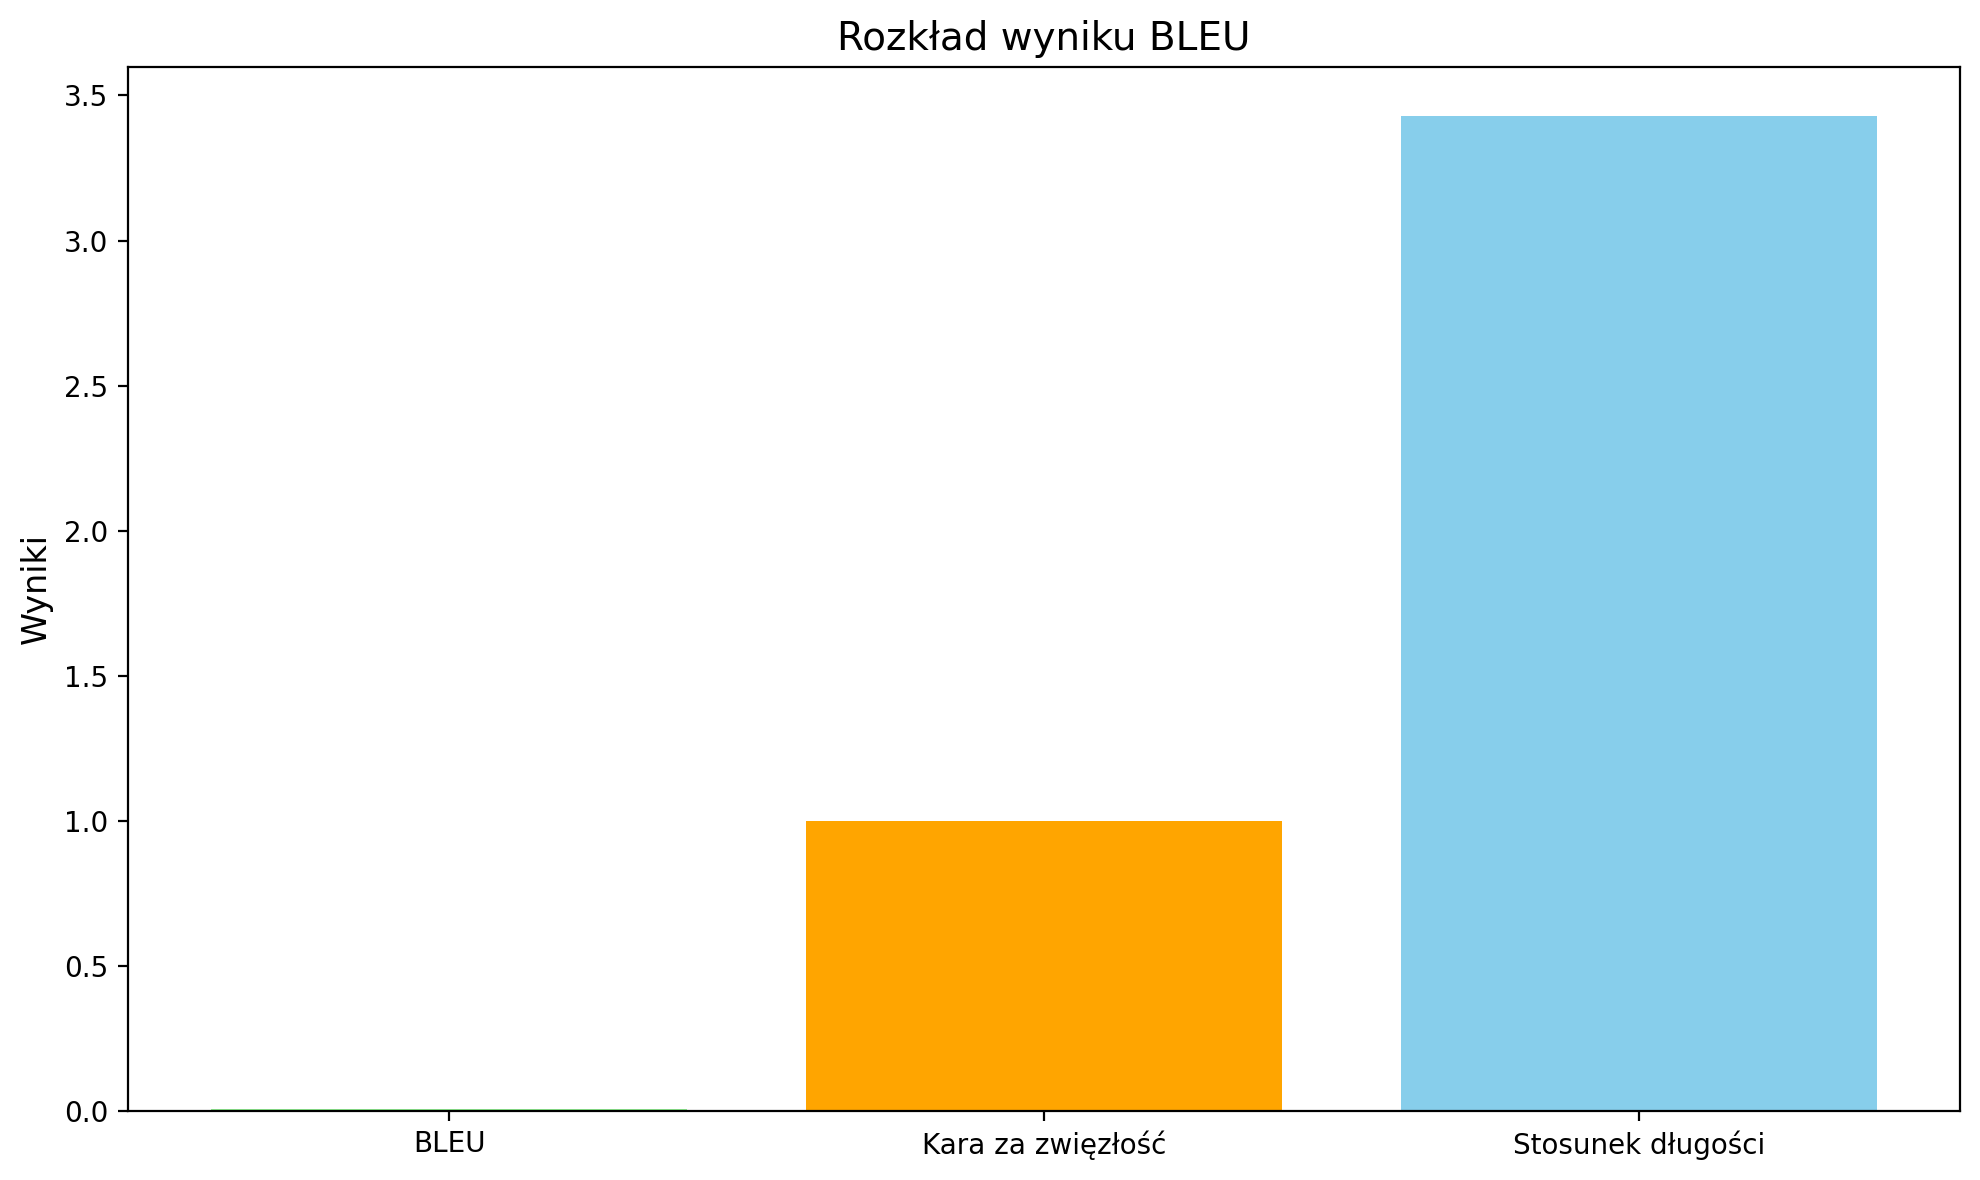

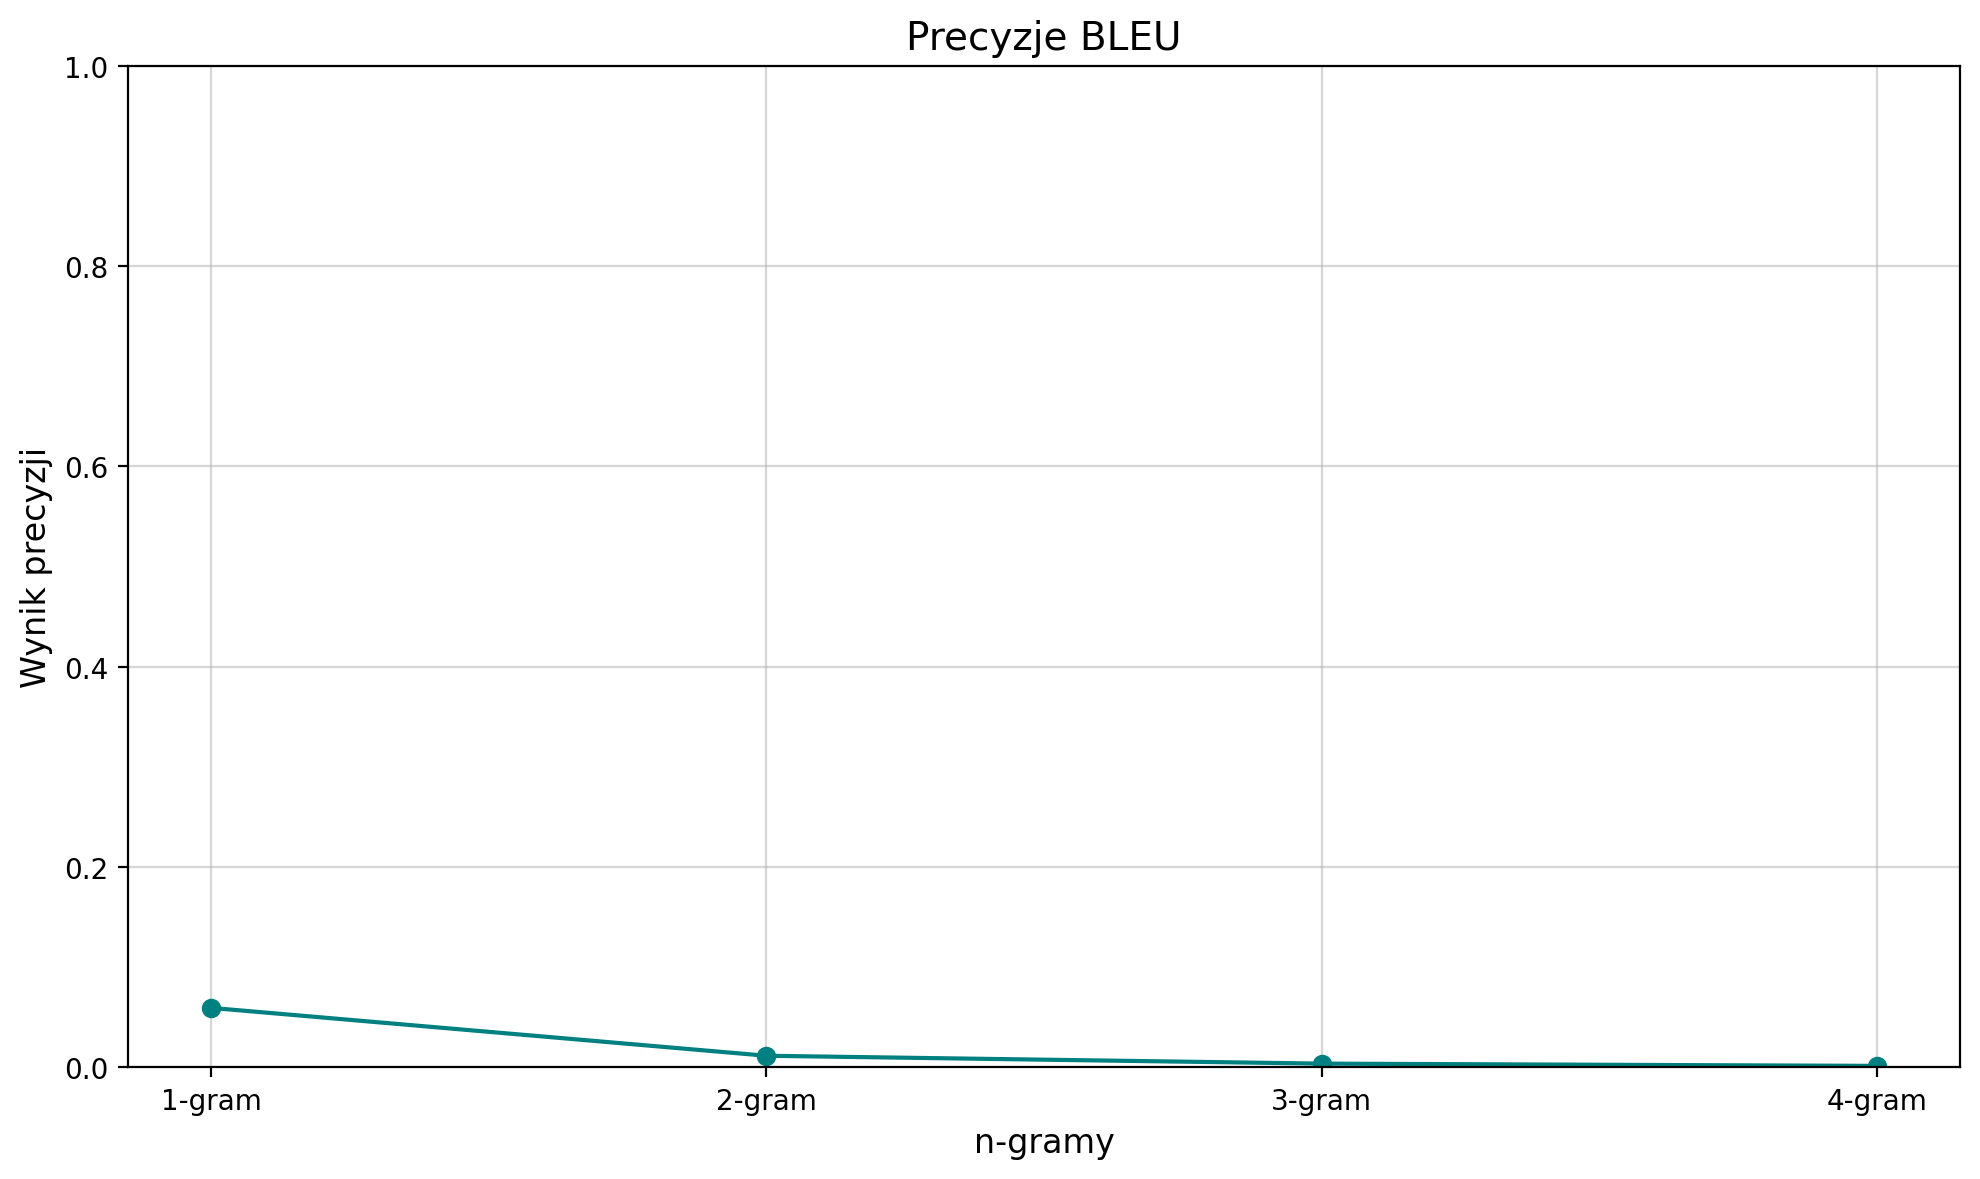

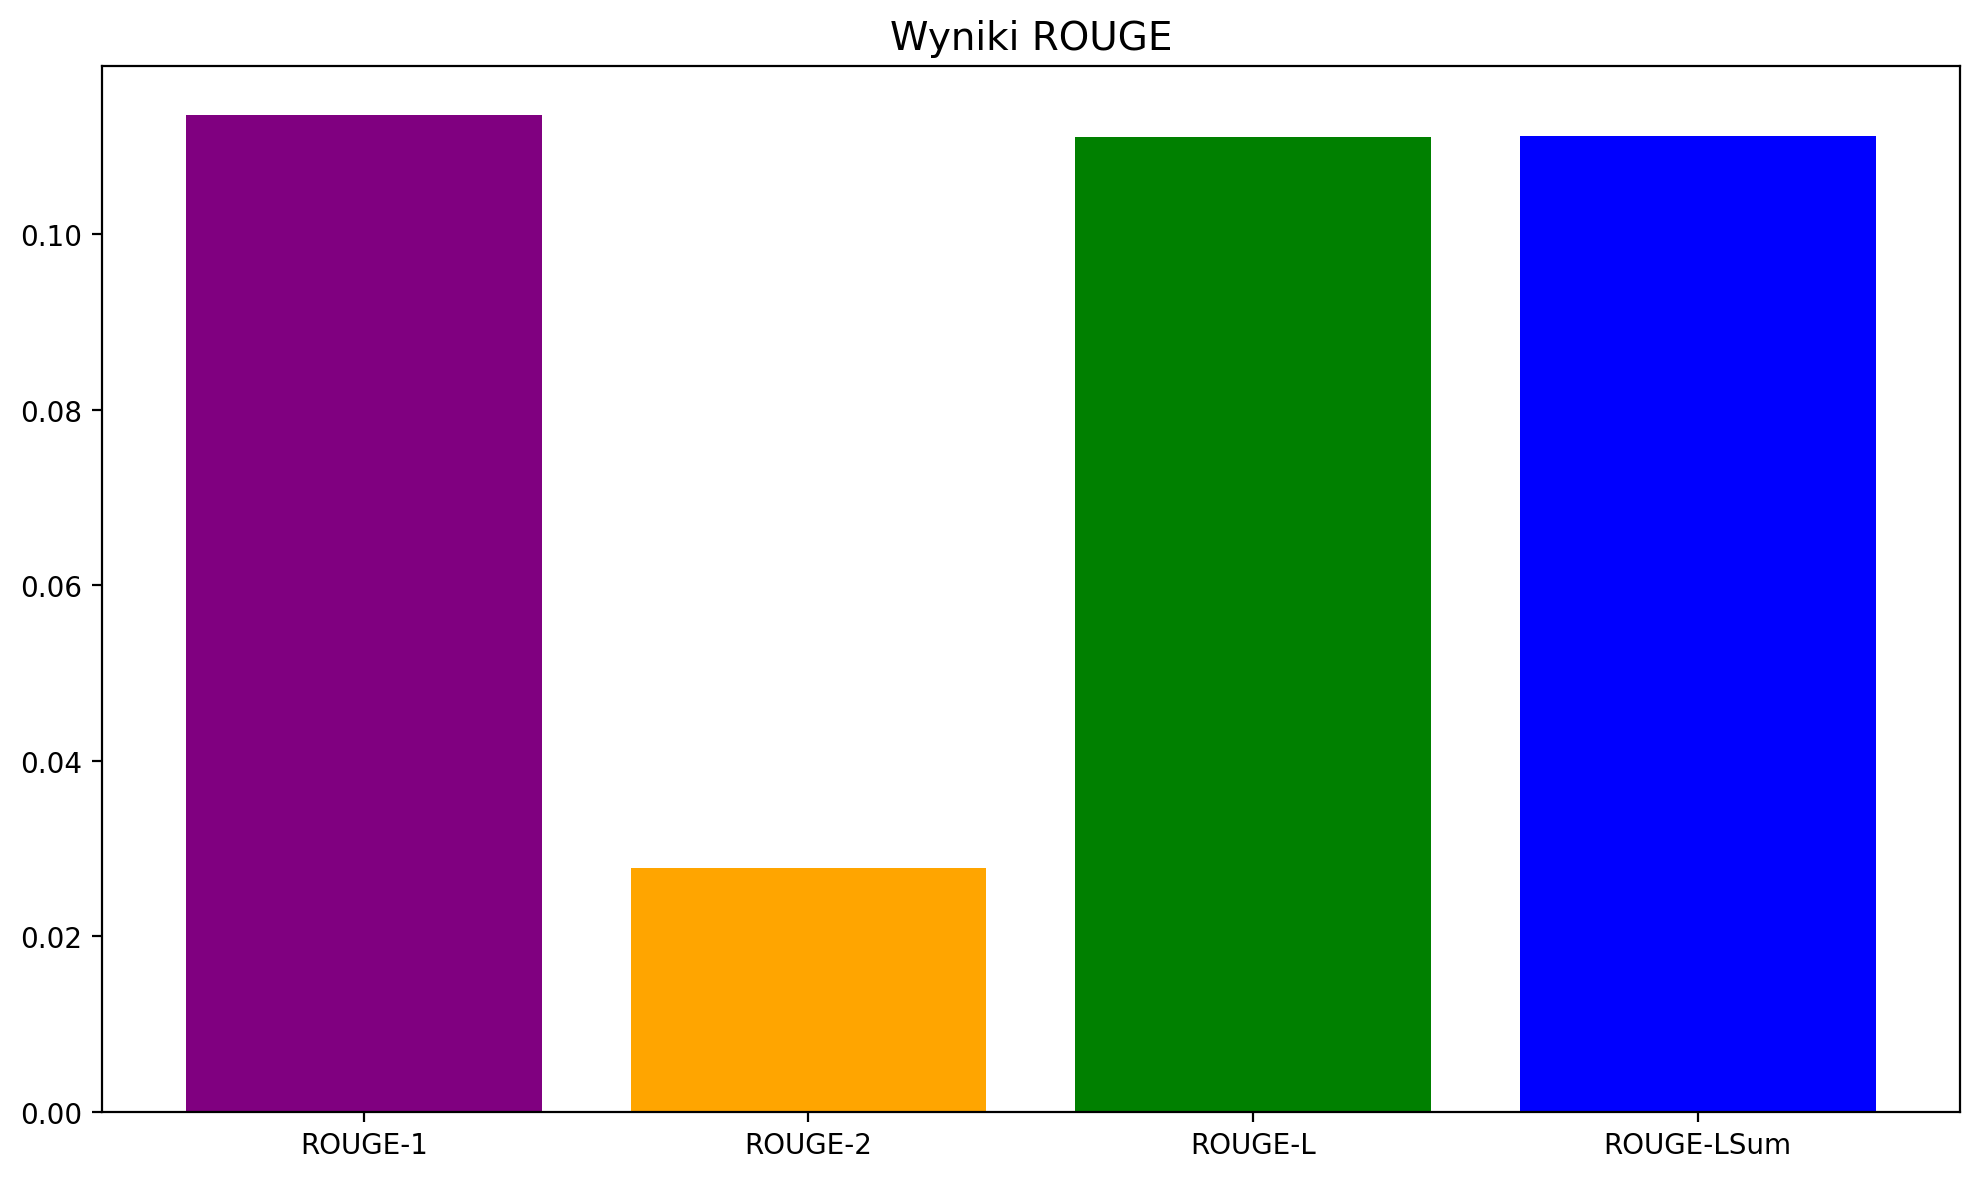

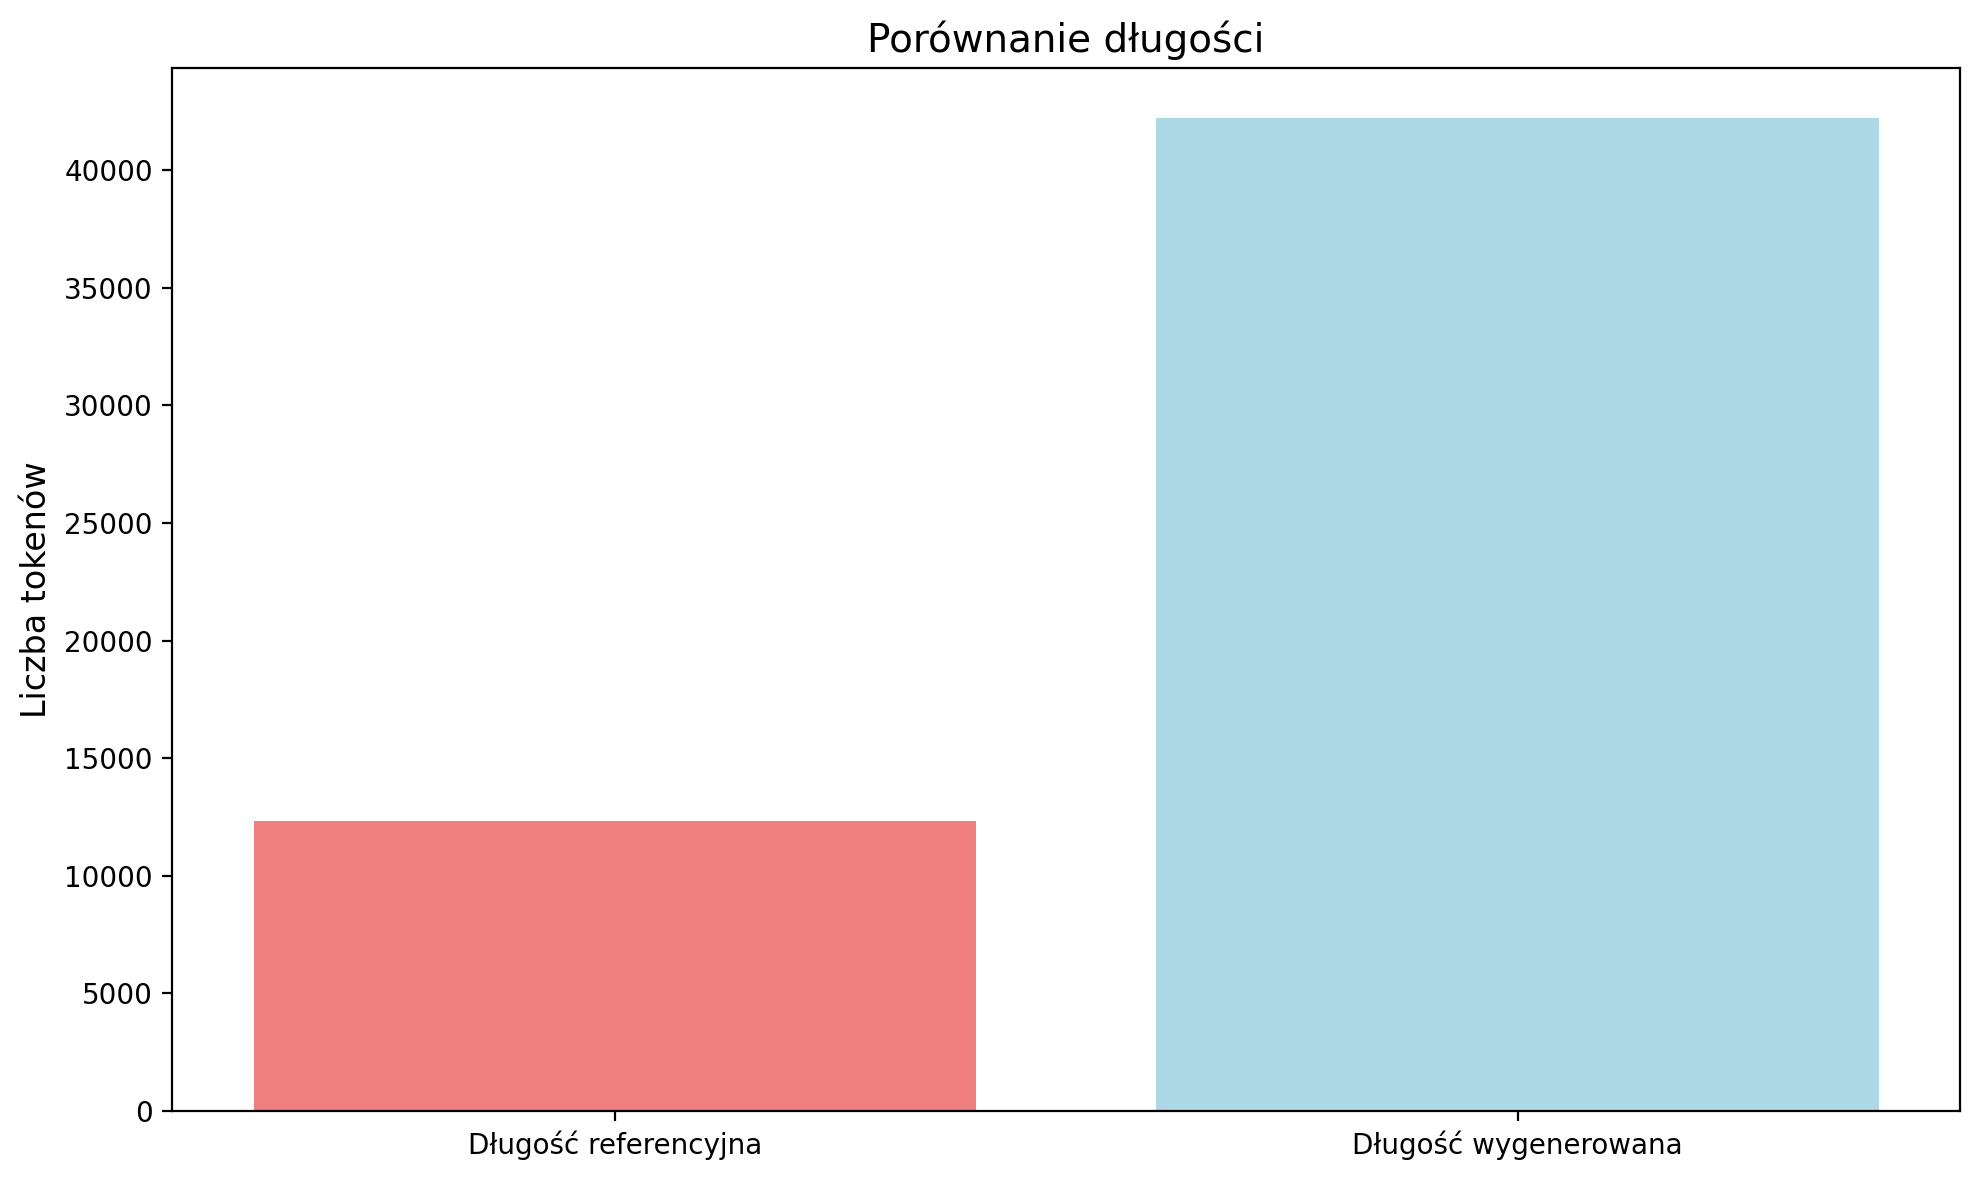

In [29]:
import matplotlib.pyplot as plt
metrics = eval_dict

# 1. Wykres dokładności
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(["Dokładność"], [metrics["accuracy"]], color="skyblue")
plt.title("Przegląd dokładności", fontsize=14)
plt.xlabel("Wynik", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Rozkład wyniku BLEU
bleu = metrics["bleu"]
plt.figure(figsize=(10, 6), dpi=200)
categories = ["BLEU", "Kara za zwięzłość", "Stosunek długości"]
values = [bleu["bleu"], bleu["brevity_penalty"], bleu["length_ratio"]]
plt.bar(categories, values, color=["lightgreen", "orange", "skyblue"])
plt.title("Rozkład wyniku BLEU", fontsize=14)
plt.ylabel("Wyniki", fontsize=12)
plt.tight_layout()
plt.show()

# Precyzje BLEU
plt.figure(figsize=(10, 6), dpi=200)
precisions = bleu["precisions"]
plt.plot(
    [f"{i+1}-gram" for i in range(len(precisions))],
    precisions,
    marker="o",
    color="teal"
)
plt.title("Precyzje BLEU", fontsize=14)
plt.ylabel("Wynik precyzji", fontsize=12)
plt.xlabel("n-gramy", fontsize=12)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Wyniki ROUGE
rouge = metrics["rouge"]
plt.figure(figsize=(10, 6), dpi=200)
categories = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-LSum"]
values = [rouge["rouge1"], rouge["rouge2"], rouge["rougeL"], rouge["rougeLsum"]]
plt.bar(categories, values, color=["purple", "orange", "green", "blue"])
plt.title("Wyniki ROUGE", fontsize=14)
plt.ylabel("", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Porównanie długości
ref_len = bleu["reference_length"]
trans_len = bleu["translation_length"]
plt.figure(figsize=(10, 6), dpi=200)
plt.bar(
    ["Długość referencyjna", "Długość wygenerowana"],
    [ref_len, trans_len],
    color=["lightcoral", "lightblue"]
)
plt.title("Porównanie długości", fontsize=14)
plt.ylabel("Liczba tokenów", fontsize=12)
plt.tight_layout()
plt.show()